In [4]:
import networkx as nx
import osmnx as ox
from IPython.display import IFrame
import geopandas as gdp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
ox.config(use_cache=True, log_console=True)
%matplotlib inline
ox.__version__

c:\ProgramData\Miniconda3\envs\ox\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


'1.2.2'

In [2]:
# downloding the street network
place = "Trier, Germany"
#cf = '["highway"~"motorway"]'
#cf =  '["highway"~"primary"]'
#G = ox.graph_from_place("Trier, Germany", network_type= "drive") ### graph of the given city
G = ox.graph_from_place(place, network_type="drive")

In [3]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)


G = ox.elevation.add_edge_grades(G, add_absolute=True)

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [4]:
## 1. convert the graph to geodataframe 
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [ ]:
gdf_edges

In [6]:
# we have gdf_edges, gdf_nodes of Triers drivable roads

### lets find shortest path for non degreded situation for arbitrarily selected source and destination

def shortest_path(origin, destination, G):
    x_orig = origin['lat']
    y_origin = origin['lon']
    x_dest = destination['lat']
    y_dest = destination['lon']
    orig = ox.distance.nearest_nodes(G, X = x_orig, Y = y_origin) # saarstraße
    dest = ox.distance.nearest_nodes(G, X = x_dest, Y = y_dest) # germanstraße, gervasiusstraße
    route = ox.shortest_path(G, orig, dest, weight = "travel_time")
    m = ox.plot_route_folium(G, route, weight=10)
    filepath = r'C:\Users\looka\OneDrive\Desktop\RCS\shortest_1.html'
    m.save(filepath)
    IFrame(filepath, width=600, height = 500)
    return route

In [7]:

origin = {'lat': 6.639066, 'lon': 49.751096}
destination = {'lat': 6.628289, 'lon': 49.751833}

short_route = shortest_path(origin, destination, G)

In [ ]:
short_route

In [9]:
# getting the nodes of non degreded shortest route
def get_nodes(short_route):
    node_df = gdp.GeoDataFrame()
    for i in short_route:
        node_df = node_df.append((gdf_nodes.loc[[i]]))
    return node_df

In [10]:
nodes = get_nodes(short_route)


C:\Users\looka\AppData\Local\Temp\ipykernel_25976\4197316962.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  node_df = node_df.append((gdf_nodes.loc[[i]]))
C:\Users\looka\AppData\Local\Temp\ipykernel_25976\4197316962.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  node_df = node_df.append((gdf_nodes.loc[[i]]))
C:\Users\looka\AppData\Local\Temp\ipykernel_25976\4197316962.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  node_df = node_df.append((gdf_nodes.loc[[i]]))
C:\Users\looka\AppData\Local\Temp\ipykernel_25976\4197316962.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  node_df = node_df.append((gdf_nodes.loc[[i]]))
C:\U

In [ ]:
nodes

In [12]:
# getting the edges of non degreded shortest route
def get_edges(short_route):
    edge_df = gdp.GeoDataFrame()
    for i in short_route:
        edge_df = edge_df.append(gdf_edges.loc[(i, slice(None), slice(None)),:])
    return edge_df

In [ ]:
edges = get_edges(short_route)

In [ ]:
edges

In [ ]:
short_route[-1]

In [ ]:
new_route = short_route[0:]
new_route

In [17]:
# simplify the dataset
def dataset(edges):       
    new_df = gdp.GeoDataFrame(data=None, index=None, columns=['source', 'destination','osmid', 'oneway', 'lanes', 'name', 'highway', 'reversed', 'length',
            'maxspeed', 'geometry'])
    c = 0
    new_orig = short_route[0]
    #new_dest = dest
    #get_u = 0
    #get_v = 0
    #temp = 'NaN'
    #,df_edge.loc[index[0],:].loc[index[1]],
    for i in new_route:
        # node = u, under that node there is multiple node as v --- accessing the v
        #print(i)
        for index, j in edges.iterrows():
                if index[0] == new_orig and index[1] == i:
                    src = index[0]
                    dest = index[1]
                    osmid = j['osmid']
                    one_way = j['oneway']
                    lanes = j['lanes']
                    #print(max(int(lanes)))
                    name = j['name']
                    highway = j['highway']
                    reveresed = j['reversed']
                    length = j['length']
                    max_speed = j['maxspeed'] 
                    geometry = j['geometry']
                    new_df = new_df.append({'source' : src, 'destination' : dest, 'osmid' : osmid, 'oneway': one_way, 'lanes' : lanes, 'name' : name, 'highway' : highway, 'reversed' : reveresed, 'length' : length,
                                                'maxspeed' : max_speed, 'geometry' : geometry}, ignore_index=True)
        new_orig = i
    return new_df 

In [ ]:
new_df = dataset(edges)

In [ ]:
new_df

In [ ]:
paths_data = gdp.GeoDataFrame(data=None, index=None, columns=['source', 'destination','degreded_edge','route_length(meters)', 'travel_time(seconds)', 'total_edges', 'total_nodes'])
# new_df is best route for non degreded situation

# intial route info enter into the paths data
route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, short_route, "length")))
route_travel_time  =  int(sum(ox.utils_graph.get_route_edge_attributes(G, short_route, "travel_time")))

paths_data  = paths_data.append({'source' : short_route[0], 'destination' : short_route[-1],'degreded_edge': 'Nan', 'route_length(meters)': route_length, 
                                'travel_time(seconds)': route_travel_time, 'total_edges' : len(new_df) - 1, 'total_nodes' : len(new_df)}, ignore_index=True)

In [ ]:
paths_data

In [23]:
new_gdf_edges = gdf_edges.copy(deep=True)
new_gdf_nodes = gdf_nodes.copy(deep=True)

In [24]:
for i in range(len(new_df)):
    #print('source: ',new_df.loc[(i),:]['source'])
    #print('destination: ',new_df.loc[(i),:]['destination'])

    select_edge = edges.loc[(new_df.loc[(i),:]['source'], new_df.loc[(i),:]['destination'], slice(None)),:] # selecting the subedge from the route as degerded edge
    #print('selected edge: ',select_edge)

    new_gdf_edges = new_gdf_edges.drop(index=(new_df.loc[(i),:]['source'], new_df.loc[(i),:]['destination']))

    new_G = ox.utils_graph.graph_from_gdfs(new_gdf_nodes, new_gdf_edges, graph_attrs=None)

    # impute speed on all edges missing data
    new_G = ox.add_edge_speeds(new_G)
    # calculate travel time (seconds) for all edges
    new_G = ox.add_edge_travel_times(new_G)
    #  convert graph to nodes and edges dataframe
    new_gdf_nodes, new_gdf_edges = ox.graph_to_gdfs(new_G)

    # again find the shortest route after missing the degreded edge
    new_short_path = shortest_path(origin, destination, new_G) #  new shortrest path actually represent route

    route_length = int(sum(ox.utils_graph.get_route_edge_attributes(new_G, new_short_path, "length")))
    route_travel_time  =  int(sum(ox.utils_graph.get_route_edge_attributes(new_G, new_short_path, "travel_time")))

    # get the nodes of new short path
    new_nodes = get_nodes(new_short_path)
    # get the edges of new short path
    new_edges = get_edges(new_short_path)

    paths_data  = paths_data.append({'source' : new_short_path[0], 'destination' : new_short_path[-1],'degreded_edge': (new_df.loc[(i),:]['source'], new_df.loc[(i),:]['destination']), 'route_length(meters)': route_length,
                                     'travel_time(seconds)': route_travel_time, 'total_edges' : len(new_nodes) - 1, 'total_nodes' : len(new_nodes)}, ignore_index=True)



C:\Users\looka\AppData\Local\Temp\ipykernel_25976\1669631397.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  new_gdf_edges = new_gdf_edges.drop(index=(new_df.loc[(i),:]['source'], new_df.loc[(i),:]['destination']))
C:\Users\looka\AppData\Local\Temp\ipykernel_25976\4197316962.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  node_df = node_df.append((gdf_nodes.loc[[i]]))
C:\Users\looka\AppData\Local\Temp\ipykernel_25976\4197316962.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  node_df = node_df.append((gdf_nodes.loc[[i]]))
C:\Users\looka\AppData\Local\Temp\ipykernel_25976\4197316962.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  node_df = node_df.append((gdf_nodes.loc[[i]]))
C:\Use

In [25]:
paths_data

,source,destination,degreded_edge,route_length(meters),travel_time(seconds),total_edges,total_nodes
0,268656889,60365100,Nan,1194,92,14,15
1,268656889,60365100,"(268656889, 1428980932)",1376,99,15,16
2,268656889,60365100,"(1428980932, 20909627)",1376,99,15,16
3,268656889,60365100,"(20909627, 3325983705)",1376,99,15,16
4,268656889,60365100,"(3325983705, 322854916)",1499,116,18,19
5,268656889,60365100,"(322854916, 322854921)",2517,181,24,25
6,268656889,60365100,"(322854921, 10602410)",2517,181,24,25
7,268656889,60365100,"(10602410, 10602396)",3126,260,30,31
8,268656889,60365100,"(10602396, 3328610208)",3077,269,29,30
9,268656889,60365100,"(3328610208, 3328610215)",3077,269,29,30


In [26]:
time = paths_data['travel_time(seconds)'][0]
path = paths_data['total_edges'][0]
paths_data['LOS']  = 0

In [27]:
#i=1
#for i in range(len(paths_data)):
paths_data['LOS'] = (paths_data['travel_time(seconds)'] - time) / paths_data['total_edges']

#print(paths_data)


In [28]:
paths_data

,source,destination,degreded_edge,route_length(meters),travel_time(seconds),total_edges,total_nodes,LOS
0,268656889,60365100,Nan,1194,92,14,15,0.0
1,268656889,60365100,"(268656889, 1428980932)",1376,99,15,16,0.466667
2,268656889,60365100,"(1428980932, 20909627)",1376,99,15,16,0.466667
3,268656889,60365100,"(20909627, 3325983705)",1376,99,15,16,0.466667
4,268656889,60365100,"(3325983705, 322854916)",1499,116,18,19,1.333333
5,268656889,60365100,"(322854916, 322854921)",2517,181,24,25,3.708333
6,268656889,60365100,"(322854921, 10602410)",2517,181,24,25,3.708333
7,268656889,60365100,"(10602410, 10602396)",3126,260,30,31,5.6
8,268656889,60365100,"(10602396, 3328610208)",3077,269,29,30,6.103448
9,268656889,60365100,"(3328610208, 3328610215)",3077,269,29,30,6.103448


In [29]:
paths_data.to_csv (r'C:\Users\looka\OneDrive\Desktop\RCS\initial_result.csv', index = None,sep='\t', encoding='utf-8', header='true') 

In [30]:
len(new_short_path)

30

In [29]:
# temp_data = paths_data.loc[1:]
# print(time)
# print(path)
# temp_data['LOS'] = (temp_data['travel_time(seconds)'] - time) /  temp_data['total_edges']

In [30]:
origin = {'lat': 6.639066, 'lon': 49.751096}
destination = {'lat': 6.628289, 'lon': 49.751833}



### best shortest route

In [ ]:
#short_route = shortest_path(origin, destination, G)
#route_edges = get_edges(short_route)

x_orig = origin['lat']
y_origin = origin['lon']
x_dest = destination['lat']
y_dest = destination['lon']
orig = ox.distance.nearest_nodes(G, X = x_orig, Y = y_origin) # saarstraße
dest = ox.distance.nearest_nodes(G, X = x_dest, Y = y_dest) # germanstraße, gervasiusstraße
best_route = ox.shortest_path(G, orig, dest, weight = "travel_time")
m = ox.plot_route_folium(G, best_route, weight=10)
filepath = r'C:\Users\looka\OneDrive\Desktop\RCS\best_shortest.html'
m.save(filepath)
IFrame(filepath, width=600, height = 500)
#short_route1

### best route graph

In [ ]:
# nodes
first_nodes = get_nodes(best_route)
first_edges = get_edges(best_route)


In [ ]:
first_edges

In [34]:
best_rout_G = ox.utils_graph.graph_from_gdfs(first_nodes, first_edges, graph_attrs=None)

### worst shortest route

In [ ]:
short_route1 = shortest_path(origin, destination, new_G)
route_edges = get_edges(short_route1)

x_orig = origin['lat']
y_origin = origin['lon']
x_dest = destination['lat']
y_dest = destination['lon']
orig = ox.distance.nearest_nodes(new_G, X = x_orig, Y = y_origin) # saarstraße
dest = ox.distance.nearest_nodes(new_G, X = x_dest, Y = y_dest) # germanstraße, gervasiusstraße
worst_route = ox.shortest_path(new_G, orig, dest, weight = "travel_time")
m = ox.plot_route_folium(new_G, worst_route, weight=10)
filepath = r'C:\Users\looka\OneDrive\Desktop\RCS\worst_shortest.html'
m.save(filepath)
IFrame(filepath, width=600, height = 500)
#short_route1

### worst route graph

In [ ]:
last_nodes = get_nodes(worst_route)
last_edges = get_edges(worst_route)
last_rout_G = ox.utils_graph.graph_from_gdfs(last_nodes, last_edges, graph_attrs=None)

In [ ]:
routes = [best_route, worst_route]
rc = ["g", "r"]

m = ox.plot_route_folium(G, best_route, weight=10)
filepath = r'C:\Users\looka\OneDrive\Desktop\RCS\two_routes.html'
m.save(filepath)
IFrame(filepath, width=600, height = 500)

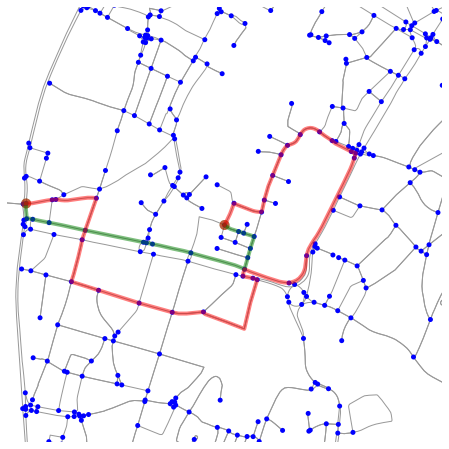

In [38]:
# constrain plot to a bounding box
#pt = ox.graph_to_gdfs(G, edges=False).unary_union.centroid
bbox = ox.utils_geo.bbox_from_point((49.751096, 6.639066), dist=850)
fig, ax = ox.plot_graph_routes(G, routes, ['g', 'r'], bbox=bbox, bgcolor ='w',node_color='b',node_size = 25)



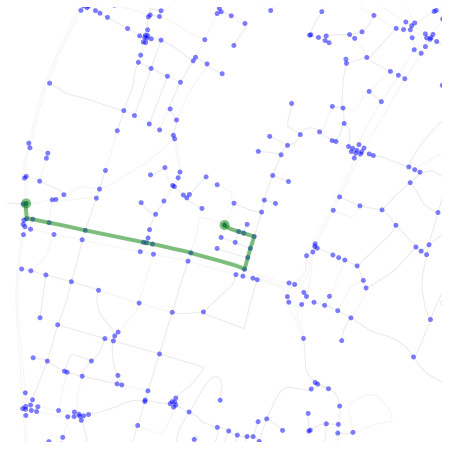

In [39]:
#ec = ox.plot.get_edge_colors_by_attr(G, attr="length", num_bins=5)
bbox = ox.utils_geo.bbox_from_point((49.751096, 6.639066), dist=850)
fig, ax = ox.plot_graph_route(G, best_route,'g', bbox=bbox, bgcolor ='w',node_color='b',node_size = 25, edge_alpha = 0.1, node_alpha = 0.5)


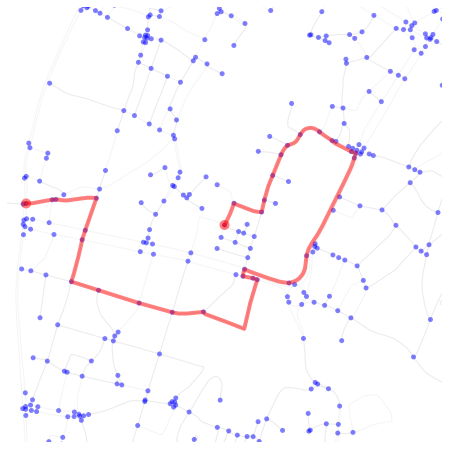

In [40]:
#ec = ox.plot.get_edge_colors_by_attr(G, attr="length", num_bins=5)
bbox = ox.utils_geo.bbox_from_point((49.751096, 6.639066), dist=850)
fig, ax = ox.plot_graph_route(G, worst_route,'r', bbox=bbox, bgcolor ='w',node_color='b',node_size = 25, edge_alpha = 0.1, node_alpha = 0.5)

In [41]:


best_rout_G = ox.utils_graph.graph_from_gdfs(new_gdf_nodes, new_gdf_edges, graph_attrs=None)

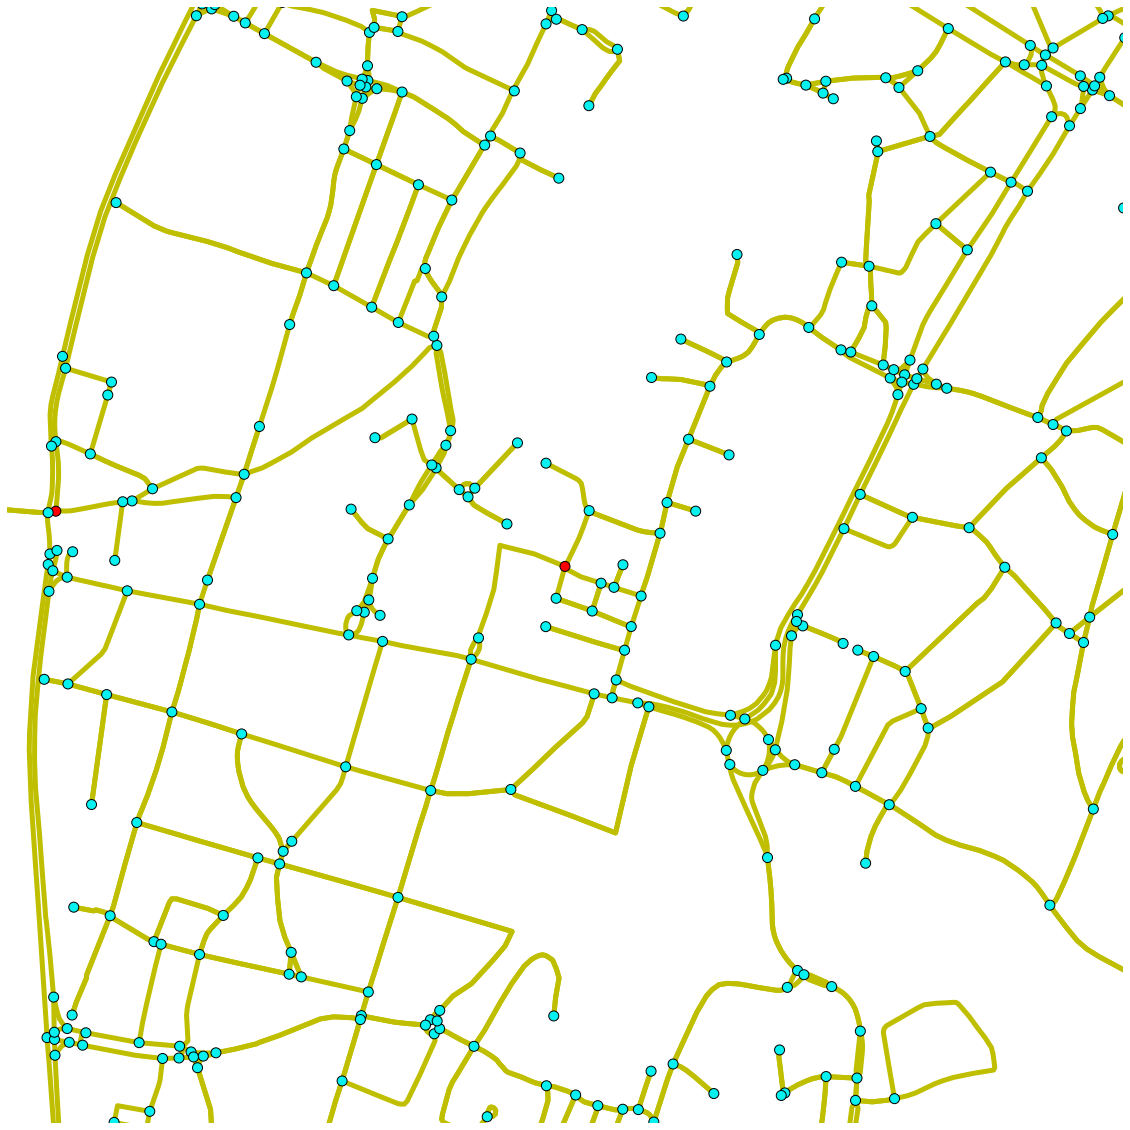

In [42]:
#ox.config(use_cache=True, log_console=True)

bbox = ox.utils_geo.bbox_from_point((49.751096, 6.639066), dist=850)
ec = ['b' if (u==60365099 and v==60365100) else 'y' for u, v, k in best_rout_G.edges(keys=True)]
nc = ['r' if (osmid==268656889 or osmid==60365100) else '#07F1F1' for osmid in best_rout_G.nodes]
#best_rout_G = ox.get_undirected(best_rout_G)
fig, ax = ox.plot_graph(best_rout_G, node_color=nc, node_edgecolor='k', node_size=100,bgcolor ='w', figsize = (20, 50),
                           node_zorder=3, edge_color=ec, edge_linewidth=5, bbox = bbox)
#fig, ax = ox.plot_graph_route(G, worst_route,'r', bbox=bbox, bgcolor ='w',node_color='b',node_size = 25, edge_alpha = 0.1, node_alpha = 0.5)
# for _, edge in ox.graph_to_gdfs(best_rout_G, nodes=False).fillna('').iterrows():
#     c = edge['geometry'].centroid
#     text = edge['name']
#     ax.annotate(text, (c.x, c.y), c='r')
# plt.show()

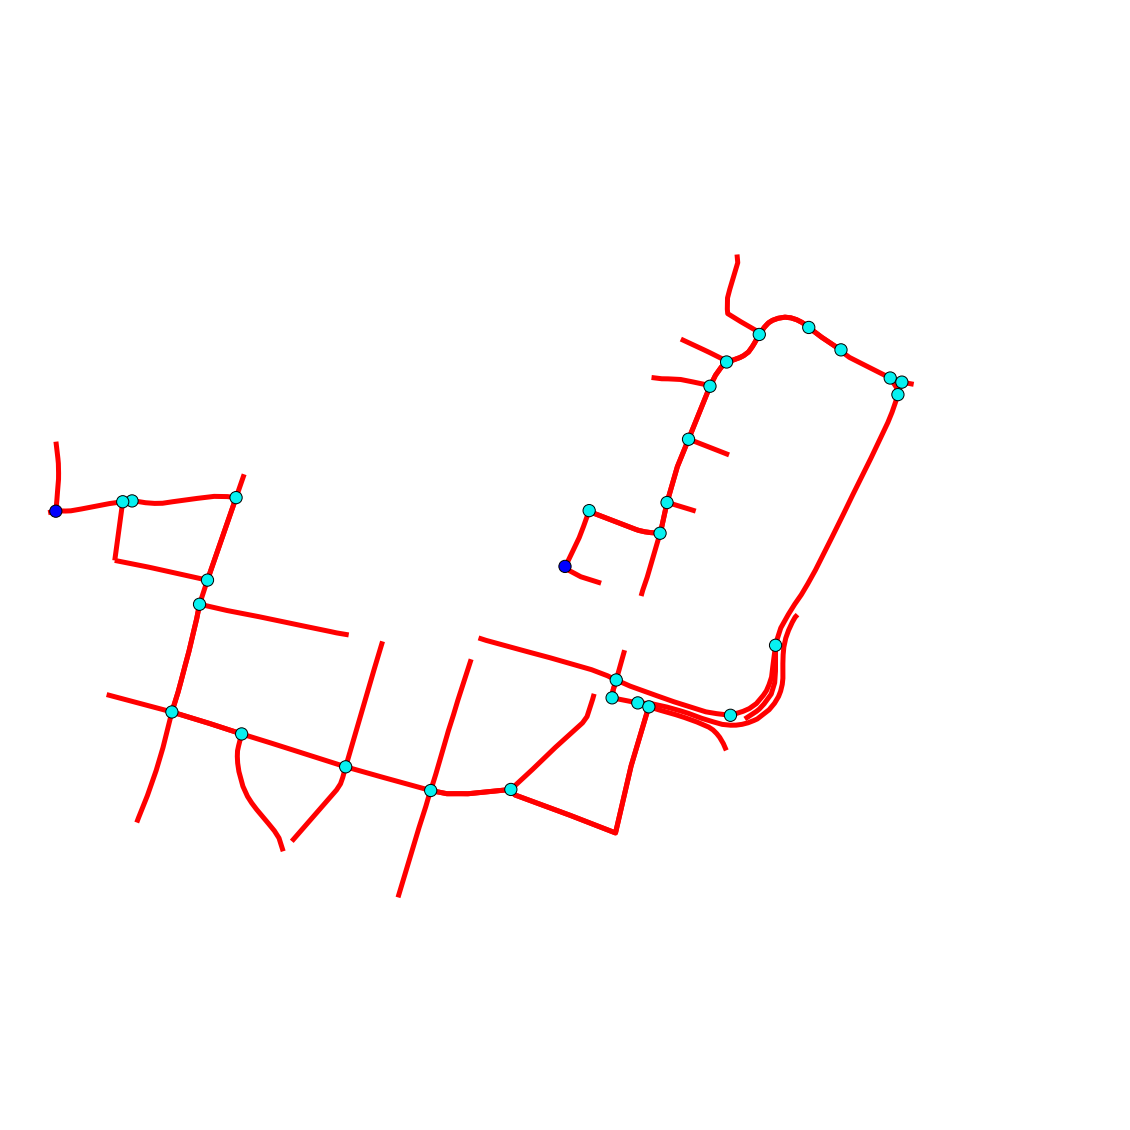

KeyError: 'x'

In [43]:
bbox = ox.utils_geo.bbox_from_point((49.751096, 6.639066), dist=850)
#ec = ['b' if (u==60365099 and v==60365100) else 'y' for u, v, k in last_rout_G.edges(keys=True)]
nc = ['b' if (osmid==268656889 or osmid==60365100) else '#07F1F1' for osmid in last_rout_G.nodes]
#best_rout_G = ox.get_undirected(best_rout_G)
fig, ax = ox.plot_graph(last_rout_G, node_color=nc, node_edgecolor='k', node_size=150,bgcolor ='w', figsize = (20, 50),
                           node_zorder=3, edge_color='r', edge_linewidth=5, bbox = bbox)

another_G = ox.get_undirected(last_rout_G)
for _, edge in ox.graph_to_gdfs(another_G).fillna(' ').iterrows():
    text = edge["name"]
    c = edge["geometry"].centroid
    print(c)
    ax.annotate(text, (c.x, c.y), c="b")
plt.show()

In [44]:
for _, gdf_edges in ox.graph_to_gdfs(G, nodes=False).fillna("").iterrows():
    text = gdf_edges["name"]
    c = gdf_edges["geometry"].centroid
    ax.annotate(text, (c.x, c.y), c="y")
plt.show()

In [ ]:
plt.y

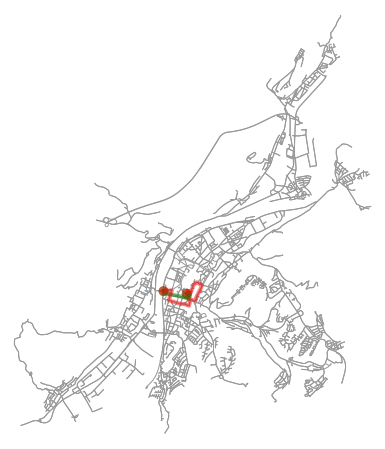

In [46]:
routes = [best_route, worst_route]
rc = ["g", "r"]
fig, ax = ox.plot_graph_routes(G, routes, route_colors=rc, route_linewidth=6, node_size=0, bgcolor ='w', close = 1)

### Presentation Overall good. We took their idea to change. 
### Examples were good, but would be easier if we use the same example over and over again would be easier to understand. Sum Up: Use the same example to explain different scenarios. Visualisation of before and after with the detours. Center of presentation should be the results, we don’t have a lot right now, but for the final we would have. Consider the comments for the paper. Selection of points of interest (we need to colect these and justify them - why are we using this combination). Recheability between hospital and house areas, have to be available in both directions. Example: hospital as final destination for neighbours (only with that we would have more than one rout). He wants: A list of start and destinations with a meaning. -> cross the river is also important to have

### Uppbound of the detour, if reach that then is not possible anymore. (Pragmatic way to deal with no nodes available).

In [ ]:

# get NY subway rail network
# note this is rail *infrastructure* and thus includes crossovers, sidings, spurs, yards, etc
# for station-based rail network, you should download a station adjacency matrix elsewhere
# ox.settings.useful_tags_way += ["railway"]
# one_G = ox.graph_from_place(
#         "Trier, Germany",
#         retain_all=False,
#         truncate_by_edge=True,
#         simplify=True,
#         custom_filter='["fire_station"~"hospital"]',
#  )

# fig, ax = ox.plot_graph(one_G, node_size=0, edge_color="w", edge_linewidth=0.2)

#### Hispitals and Fire_Station dataset

In [36]:
place = "Trier, Germany"
#tags = {"building" : True}
tags = {'amenity':['hospital','fire_station']}
gdf = ox.geometries_from_place(place, tags)
gdf.shape

(16, 39)

In [ ]:
gdf.head()

### flooded area dataset

In [2]:
from shapely import wkt

In [2]:
## polygon = wkt.loads('POLYGON (( 324128.22144089 5508677.6115805, 24186.42974279 5508677.6115805, 24255.22137231 5508677.6115805, 24318.72133802 5508677.6115805, 324376.92963992 5508677.6115805, 324413.97128659 5508629.9866062, 324440.42960563 5508640.5699338, 324488.05457991 5508571.7783043, 324503.92957134 5508534.7366577, 324482.7629161 5508629.9866062, 324445.72126944 5508667.0282529, 324445.72126944 5508709.3615634, 324514.51289896 5508730.5282186, 324572.72120086 5508688.1949081, 324615.05451133 5508635.27827, 324620.34617514 5508688.1949081, 324630.92950276 508762.2782015, 324678.55447704 5508735.8198824, 324763.22109799 5508772.8615291, 324832.01272751 5508809.9031757, 324906.09602084 5508794.0281843, 324937.84600369 5508788.7365205, 324895.51269322 5508883.9864691, 324879.63770179 5508931.6114433, 324921.97101227 5509010.9864005, 324969.59598655 5509037.4447195, 324980.17931417  5509090.3613576, 325075.42926273 5509074.4863662, 325128.34590082 5509042.7363833, 325223.59584939 5509095.6530214, 325297.67914272 5509106.2363491, 325313.55413414 5509175.0279786, 325271.22082367 5509222.6529529, 325271.22082367 5509243.8196081, 325345.304117 5509259.6945995, 325355.88744462 5509280.8612548, 325377.05409985 5509249.1112719, 325419.38741033 5509217.361289, 325456.42905699 5509206.7779614, 325477.59571223 5509270.2779271, 325519.9290227 5509280.8612548, 325567.55399698 5509249.1112719, 325599.30397984 5509259.6945995, 325657.51228174 5509264.9862633, 325715.72058364 5509312.6112376, 325773.92888554 5509349.6528843, 325816.26219601 5509365.5278757,325710.42891983 5509460.7778243, 325646.92895412 5509534.8611176, 325652.22061793 5509566.6111004, 325683.97060079 5509556.0277728, 325715.72058364 5509529.5694538, 325742.17890269 5509545.4444452, 325863.8871703 5509434.3195052, 325900.92881696 5509434.3195052, 326043.80373981 5509545.4444452, 325964.42878267 5509645.9860576, 325916.80380839 5509624.8194023, 325879.76216172 5509571.9027643, 325816.26219601 5509577.1944281, 325763.34555792  5509598.3610833, 325795.09554078  5509624.8194023, 325784.51221316 5509693.6110319, 325810.97053221 5509735.9443423, 325848.01217887 5509762.4026614, 325895.63715315 5509751.8193338, 325943.26212743 5509757.1109976, 325916.80380839 5509804.7359719, 325975.01211029 5509746.52767, 325996.17876553 5509688.3193681, 326080.84538647 5509656.5693852, 326128.47036076 5509683.0277043, 326144.34535218 5509667.1527128, 326181.38699885 5509677.7360404, 326176.09533504 5509714.7776871, 326128.47036076 5509746.52767, 326096.7203779 5509757.1109976, 326075.55372266 5509751.8193338, 326027.92874838 5509794.1526442, 325985.59543791 5509788.8609804, 325964.42878267 5509841.7776185,325990.88710172 5509915.8609119, 326059.67873124 5509915.8609119, 326170.80367123 5509963.4858861, 326303.09526646 5510143.4024556, 326331.08444775 5510149.42548, 326399.87607727 5510109.7380014, 326516.29268107 5510085.9255143,326595.66763821 5510046.2380357, 326553.33432774 5510125.6129929, 326614.18846154 5510149.42548, 326643.29261249 5510130.9046567, 326669.75093154 5510091.2171781, 326733.25089725 5510120.321329, 326714.73007392 5510181.1754629,326926.39662628 5510239.3837648, 326950.20911342 5510212.9254457, 327000.47991961 5510255.2587562, 327140.70901056 5510406.0711747, 327296.81309293 5510580.6960804, 327323.27141197 5510641.5502143, 327294.16726102 5510662.7168695, 327304.75058864 5510705.05018, 327130.12568294 5510887.6125814, 327254.47978245 5511004.0291852, 327235.95895912 5511027.8416723, 327331.20890769 5511144.2582761, 327283.5839334 5511207.7582418, 327569.3337791 5511538.4872299, 327733.37535718 5511416.7789623, 327757.18784432 5511456.4664409, 327614.31292148 5511554.3622213, 327619.60458528 5511594.0496999, 327632.83374481 5511607.2788594, 327646.06290433 5511586.1122042, 327646.06290433  5511559.6538851, 327667.22955957 5511541.1330618, 327815.39614622 5511448.5289451, 327897.41693527 5511575.5288766, 327796.87532289 5511665.4871613, 27810.10448241 5511702.528808, 327812.75031432 5511673.424657, 327873.60444812 5511615.2163551, 327852.43779289 5511652.2580018, 327902.70859908 5511639.0288423, 327958.27106907 5511728.987127, 327833.91696956 5511818.9454118, 327796.87532289 5511755.4454461, 327773.06283575 5511776.6121013, 328035.0001943 5512065.0077789, 328056.16684954 5512049.1327875, 328074.68767287 5511993.5703175, 328095.85432811 5512054.4244513, 328124.95847906 5512043.8411237, 328238.72925096 5511943.2995113, 328143.47930239 5512059.7161151,328191.10427667 5512091.466098, 328212.27093191 5512199.9452061, 328246.66674667 5512207.8827018, 328273.12506572 5512186.7160465, 328283.70839334 5512184.0702146, 328302.22921667 5512221.1118613, 328265.18757 5512244.9243484,328257.25007429 5512266.0910037, 328262.5417381 5512303.1326503, 328418.64582047 5512493.6325475, 328595.91655808 5512464.5283965, 328693.81233855 5512382.5076075, 328720.27065759 5512382.5076075, 328757.31230426 5512342.8201289, 328823.45810187 5512329.5909694, 328839.3330933 5512348.1117927, 328820.81226997 5512393.0909351, 328810.22894235 5512451.299237, 328804.93727854 5512464.5283965, 328826.10393378 5512461.8825646, 328857.85391663  5512668.2574532, 328820.81226997 5512694.7157722, 328799.64561473 5512657.6741255, 328619.72904522 5512721.1740913, 328516.54160094 5512655.0282936, 328587.97906236 5512567.7158408, 328672.64568331  5512475.1117241,328654.12485998  5512446.0075732, 328585.33323046  5512480.4033879,328540.35408808  5512522.7366984, 328490.08328189  5512625.9241427,328355.14585476  5512488.3408837, 328278.41672953  5512406.3200946,328214.91676382  5512448.6534051, 328281.06256143  5512501.5700432,328468.91662666  5512662.9657894, 328389.64564266  5512747.1161466,328294.39569409  5512651.8661981, 328344.66650028  5512575.1370728,328267.93737505  5512516.9287709,  328196.49991362  5512572.4912409,328098.60413315  5512654.51203,  328130.35411601  5512696.8453404,328196.49991362  5512662.4495257,  328273.22903886  5512747.1161466,328196.49991362  5512786.8036252, 328270.58320695  5512905.8660609,328344.66650028  5512879.4077418, 328373.77065123  5512924.3868842,328558.97888455  5512837.0744314,  328678.04132026  5513011.6993371,328715.08296692  5512987.8868499,  328500.77058265  5512707.428668,328524.58306979   5512699.4911723,  328606.60385883  5512778.8661295,328633.06217788  5512773.5744657,  328667.45799264  5512826.4911038,328654.22883312  5512837.0744314,  328746.83294978  5512982.5951861,328802.39541977  5512964.0743628,  328842.08289834  5513188.9700747,328820.91624311  5513212.7825618, 328820.91624311  5513223.3658894,328810.33291549  5513268.3450318, 328860.60372167  5513493.2407437,328902.93703215  5513493.2407437, 328934.687015    5513636.1156666,328892.35370453  5513636.1156666, 328897.64536834  5513675.8031451,328921.45785548  5513675.8031451, 328939.97867881  5513826.6155637,328961.14533405   5514088.5529222, 328932.0411831   5514096.490418,328905.58286405    5514064.7404351, 328903.00479747  5514070.1396472, 328907.7672949 5514214.6020692, 328934.22561395 5514315.6728479, 328953.27560366 5514372.8228171, 328999.84224518 5514519.4019046, 329027.35889699 5514536.8643951, 329049.58388499 5514529.4560658, 329055.93388156 5514549.0352219, 329067.04637556 5514550.6227211, 329076.04220403 5514582.3727039, 329099.85469117  5514578.1393729, 329101.9713567 5514610.9476885, 329151.18383012 5514731.0684569, 329131.07550765  5514737.4184535, 329121.02134641 5514712.5476336, 329117.31718174 5514714.6642991, 329116.25884898 5514729.4809578, 329149.59633098 5514788.7475925, 329136.36717146 5514778.1642648, 329073.92553851 5514673.3893214, 329064.40054365 5514669.1559904, 329052.75888327 5514672.860155, 329058.05054708 5514683.972649, 329042.70472204 5514692.4393111, 329032.12139442 5514717.8392974, 329038.47139099 5514731.0684569, 329030.53389527 5514738.4767863, 329039.00055737 5514749.5892803, 329062.28387813  5514734.7726216,329070.22137384  5514746.9434484, 329064.40054365  5514751.1767794,329072.86720575  5514763.8767726, 329064.92971003  5514768.1101036,329065.45887642  5514778.1642648, 329068.6338747  5514778.1642648,329089.80052994   5514767.0517708, 329095.09219375  5514778.1642648,329095.09219375   5514790.864258,  329082.92136699  5514799.8600865,329094.03386098   5514810.4434141, 329098.26719203  5514830.5517366,329088.21303079   5514837.4308995, 329100.38385756  5514854.3642237,329097.20885927   5514860.7142203, 329090.32969632  5514869.7100487,329086.09636527   5514875.5308789, 329085.03803251  5514882.4100419,329113.61301708   5514906.7516954, 329146.95049908  5514937.9725119,329160.70882498   5514944.8516748, 329149.59633098  5514953.3183369,329169.70465346   5514976.0724913,  329174.46715088  5514970.2516611,329207.80463288   5515001.4724776,  329213.09629669  5515014.7016371,329218.3879605   5515012.5849716,  329232.67545278  5515033.7516268,329231.61712002   5515036.3974587,  329230.55878726  5515039.0432906,329238.49628297  5515046.9807864,  329242.20044764  5515044.3349544,329249.60877697   5515053.3307829,  329288.76708916  5515068.1474416,329300.40874954   5515091.9599287,  329297.23375126  5515116.8307486,329309.40457802   5515158.6348927,  329318.92957287  5515177.6848824,329334.27539792   5515184.5640454,  329343.80039278  5515179.801548,329363.90871525   5515208.9056989,  329368.1420463   5515216.3140282,329379.2545403   5515217.9015274,  329388.25036877  5515213.13903,329410.47535677   5515250.1806766,  329406.77119211  5515252.2973421,329412.5920223   5515257.0598396,  329420.00035163  5515253.3556749,329423.17534991   5515257.0598396,  329415.2378542  5515264.4681689,329455.98366553   5515307.8598121,  329467.09615953  5515299.39315,329492.49614581   5515329.0264674,  329475.03365524  5515345.4306252,329473.97532248  5515361.3056166,  329465.50866039  5515375.5931089,329454.39616639  5515376.6514417,  329455.98366553  5515388.8222684,329471.85865696  5515402.0514279,  329490.90864667  5515385.1181038,329510.48780277  5515377.7097744, 329525.83362781  5515377.180608,329539.59195372   5515377.180608,  329562.3461081   5515400.4639288,329580.86693143   5515423.7472496,  329638.54606695  5515479.8388859,329635.90023504  5515496.2430437,  329640.66273247  5515507.3555377,329652.83355923  5515502.0638739,  329669.23771704  5515515.8221998,329674.52938085  5515509.4722033,  329912.12508588 5515710.0262616,329947.5792334    5515731.7220833,  329945.99173426 5515737.5429134,329976.68338435   5515760.8262342,  330193.11243415 5515876.1845052,330337.04568976   5515937.5678054,  330579.9330586  5516034.9344195,330859.33290772   5516105.8427146,   331107.51194037 5516174.6343441,331391.46169031   5516252.6046422,  331426.38667145 5516278.0046284,331431.67833526   5516291.7629544,  331518.46162173 5516349.9712563,331565.02826325   5516360.5545839,  331623.23656515 5516433.5795444,331632.76156     5516422.9962168,  331647.57821867 5516429.3462134,331663.4532101   5516465.3295273,  331750.23649657 5516530.9461585,331763.99482247  5516530.9461585,  331826.43645542 5516585.9794621,331848.66144342  5516589.1544604, 331817.96979332 5516657.9460899,331826.43645542  5516668.5294176,   331845.48644513 5516670.6460831,331861.36143656  5516661.1210882,  331875.11976246 5516652.6544261,331890.99475389  5516641.0127658, 331893.11141941 5516630.4294381,331907.92807808  5516618.7877778, 331920.62807122 5516632.5461037,331948.14472303  5516631.4877709,  331961.90304893 5516631.4877709,331977.77804036  5516631.4877709,  331975.66137484 5516619.8461105,331928.03640056  5516593.3877915, 331949.20305579 5516573.279469,332099.48630797   5516668.5294176, 332262.46955329 5516651.5960934,332354.54450357  5516646.3044296, 332459.319447   5516605.0294519,332939.80252087  5516645.2460968,333193.80238371 5516661.1210882,333219.20236999  5516569.046138, 333265.76901151 5516582.8044639,333253.06901837  5516668.5294176, 333283.76066846 5516685.4627418,333295.40232884  5516663.2377538, 333507.06888121 5516709.8043953,333546.2271934   5516851.6209854, 333619.25215397 5516889.7209648,333750.48541643  5516917.2376166, 333836.21037014 5516959.5709271,333885.95200995  5516906.654289, 333912.41032899 5516880.1959699,333912.41032899  5516872.7876406, 333899.71033585 5516833.6293284,333914.52699452  5516801.8793456, 333931.46031871 5516832.5709956,333939.9269808   5516818.8126697,  333935.69364975 5516800.8210128,333925.11032214  5516762.7210334, 333961.09363604 5516717.2127246,334005.54361203  5516761.6627006, 334037.29359489 5516760.6043678,334044.70192422  5516800.8210128, 334093.38523127 5516808.2293421,334137.83520726  5516842.0959905,  334029.88526556 5516923.5876132,334026.71026727  5516915.1209511,  334040.46859318 5516889.7209648,334039.41026041  5516877.0209716, 334011.89360861 5516877.0209716,333997.07694994  5516870.6709751,  333996.01861718 5516855.8543164,333957.91863775  5516899.2459596,  333926.1686549 5516899.2459596,333899.71033585   5516902.4209579, 333895.4770048 5516922.5292804,333893.36033928   5516954.2792633,  333925.11032214 5516992.3792427,333939.9269808   5516998.7292393,333943.10197909 5517031.5375549,333997.07694994  5517048.4708791, 334084.91856917 5517119.3791741,334142.06853831  5517164.8874829, 334264.83513868 5517521.5456236,334362.20175277  5517572.3455962,  334350.56009239 5517583.9872566,334334.68510096  5517569.1705979,  334305.05178363 5517603.0372463,334240.49348516  5517531.0706185, 334240.49348516 5517515.195627,334259.54347487   5517523.6622891, 334218.26849716 5517423.1206768,334119.84355031  5517449.5789958,  334106.08522441 5517480.2706459,334218.26849716  5517520.4872908,334216.15183164 5517531.0706185,334085.97690193  5517496.1456373,  334108.20188993 5517552.2372737,334103.96855889  5517625.2622343, 334107.14355717 5517689.8205327,334100.7935606   5517733.212176,  334094.44356403 5517778.7204847,334067.98524498  5517922.6537403,  334063.75191394 5517899.3704196,334101.85189336  5517666.537212, 334079.62690536 5517608.3289101,334015.06860689  5517527.8956202, 333939.9269808  5517483.4456442,333893.36033928   5517476.0373148,  333803.40205452 5517462.2789889,333786.46873033  5517580.8122583, 333806.57705281 5517636.9038946,333826.68537528  5517489.7956407,  333903.9436669  5517506.7289649,333903.9436669  5517518.3706253,  333934.63531699 5517521.5456236,333911.35199623 5517652.7788861, 333967.44363261 5517659.1288826,333970.61863089 5517694.0538638, 333999.19361546 5517694.0538638,333999.19361546 5517721.5705156, 334017.18527241 5517722.6288484,334022.47693622 5517710.987188, 334057.40191736 5517712.0455207,334038.35192765 5517830.5787901,  333987.55195508 5517822.112128,333978.02696023  5517866.562104,  333947.33531013 5517862.3287729,333879.60201338 5517822.112128,  333748.36875091 5517815.7621314,333734.61042501 5518041.1870097,  333746.25208539 5518047.5370062,334002.36861375 5518137.495291, 333989.66862061 5518158.6619462,333939.9269808  5518144.9036203,  333921.93532385 5518221.1035792,333871.13535128 5518214.7535826,  333877.48534785 5518151.2536169,333769.53540615 5518113.1536375,   333771.65207167 5518089.8703167,333736.72709053 5518076.1119908,  333717.67710082 5518079.2869891,333704.97710767 5518093.045315,  333704.97710767 5518116.3286358,333713.44376977 5518498.3867628,  333733.55209224 5518616.9200321,333765.3020751  5518623.2700287,  333774.82706995 5518580.9367182,333827.74370805 5518564.003394,  333830.91870633 5518634.9116891,333768.47707338 5518633.8533563,  333766.36040786 5518651.8450132,333798.11039072 5518651.8450132,  333810.81038386 5518673.0116685,333846.79369776 5518684.6533289,  333856.31869262 5518708.9949824,333847.85203052 5518741.803298,  333839.38536843 5518764.028286,333853.14369433  5518770.3782826,  333870.07701852 5518771.4366153,333880.66034614 5518785.1949412,  333838.32703566 5518778.8449447,333812.92704938 5518801.0699327,  333753.66041472 5518807.4199292,333738.84375605 5518829.6449172,  333758.95207853 5519141.853082,333737.78542329  5519140.7947492,  333721.91043186 5518951.3531848,333691.21878177 5518969.3448418,   333630.89381435 5518826.4699189,333611.84382463 5518825.4115862, 333610.78549187 5518809.5365948,333651.00213682 5518794.7199361,  333647.82713853 5518740.7449652,333706.03544044 5518715.344979, 333671.56721004 5518302.9608822,333597.48391671 5518318.8358736, 333597.48391671 5518458.1830206,333541.03950275 5518493.4607793,  333567.49782179 5518548.1413054,333514.5811837  5518576.3635124, 333555.15060624 5518701.5995558,333565.73393386 5518983.8216257,   333569.26170973 5519525.3352221,333546.33116656 5519578.2518602, 333546.33116656 5519615.2935069,333455.5429244  5519710.7262955,332934.36602577 5520158.9366715,  332786.19943911 5520285.9366029,332384.03298962 5520476.4365, 332227.04696328 5520797.4641045,332257.0330582  5520905.0612686, 332262.32472201 5520961.5056825,332311.71358423 5521040.8806397, 332350.51911883 5521109.6722692,332348.75523089 5521160.8250194, 332334.6441274  5521196.1027781,332276.4358255   5521215.5055454, 332221.75529947 5521222.5610971,332161.78310963 5521220.7972092, 332115.92202329 5521208.4499936,332068.297049   5521180.2277867, 331930.71378997 5521102.6167175,331860.15827251 5521104.3806054, 331860.15827251 5521129.0750365,331833.69995346 5521155.5333555, 331816.0610741  5521194.3388902,331759.61666014  5521273.7138473, 331743.74166871 5521344.2693647,331733.15834109 5521406.0054425,  331676.71392713 5521540.0609257,331694.35280649 5521543.5887016, 331717.28334966 5521494.1998393,331759.61666014 5521384.8387873, 331786.07497918 5521270.1860714,331814.29718616 5521220.7972092,  331879.56103981 5521199.630554,331886.61659156  5521159.0611314, 331927.18601409 5521153.7694676,331927.18601409 5521201.3944419, 332165.31088551 5521247.2555282,332172.36643725 5521266.6582955, 332308.18580835 5521243.7277524,332339.93579121 5521220.7972092, 332366.39411025 5521201.3944419,332375.21354994 5521176.7000108, 332391.08854136 5521155.5333555,332391.08854136 5521148.4778038,   332391.08854136 5521129.0750365,332391.08854136 5521097.3250536, 332362.86633438 5521021.4778724,332329.35246359 5520943.8668032,332281.72748931 5520876.8390616,332279.96360137 5520830.9779753,332290.54692899 5520741.0196905,332324.06079978 5520665.1725092,332369.92188613 5520594.6169918,332442.24129152 5520529.3531381,332595.69954198 5520465.8531724,332932.60213784 5520361.7837842,332976.69933624 5520294.7560426,333054.31040545 5520261.2421718,324128.22144089 5508677.6115805))')

In [18]:
polygon = wkt.loads('POLYGON((6.63436 49.763771, 6.638398 49.7583, 6.656425 49.768473, 6.639034 49.770436, 6.63436 49.763771))')
flood_G = ox.graph_from_polygon(polygon, network_type='drive')
flood_gdf_nodes, flood_gdf_edges = ox.graph_to_gdfs(flood_G)

# 329640.21528238 5515051.7540623,329911.85402458 5514434.3932846,331245.35330449 5515524.4760293,330000.0484214 5515782.003668,329640.21528238 5515051.7540623

In [ ]:
# # impute speed on all edges missing data
# flood_G = ox.add_edge_speeds(G)

# # calculate travel time (seconds) for all edges
# flood_G = ox.add_edge_travel_times(G)


# floo_G = ox.elevation.add_edge_grades(G, add_absolute=True)

In [ ]:

#G6 = ox.graph_from_polygon(polygon, network_type='drive')

In [47]:
#polygon = wkt.loads('POLYGON ((-122.418083 37.754154, -122.418082 37.766028, -122.410909 37.766028, -122.410908 37.754154, -122.418083 37.754154))')
#G6 = ox.graph_from_polygon(polygon, network_type='drive')

In [16]:
flood_gdf_edges.head(10)

osmid  oneway   lanes  \
u        v          key                                           
20833912 2604850303 0                 384339892    True       2   
         247373153  0                  10655442   False       3   
20833915 3307821765 0                   5583917    True       2   
         2897253810 0                 286085869    True       2   
20833916 3310626162 0    [315143431, 548574319]    True  [2, 4]   
20833918 20834107   0                   5583927    True       4   
60366894 20833918   0                 224144666    True       3   
         89989804   0                 548183525    True       2   
60375008 3683003822 0                  44503635   False       2   
         256593965  0     [10313720, 366234173]   False     NaN   

                                         name      highway  maxspeed reversed  \
u        v          key                                                         
20833912 2604850303 0               Nordallee    secondary        50    False   
         247373153  0               Nordallee    secondary        50    False   
20833915 3307821765 0            Lindenstraße  residential       NaN    False   
         2897253810 0               Nordallee    secondary        50    False   
20833916 3310626162 0            Lindenstraße    secondary        50    False   
20833918 20834107   0     Georg-Schmitt-Platz      primary        50    False   
60366894 20833918   0            Lindenstraße    secondary        50    False   
         89989804   0    Ascoli Piceno Straße      primary        50    False   
60375008 3683003822 0          Zeughausstraße  residential        50    False   
         256593965  0      Max-Brandts-Straße  residential  [50, 30]    False   

                          length  \
u        v          key            
20833912 2604850303 0     22.784   
         247373153  0     59.341   
20833915 3307821765 0     13.871   
         2897253810 0     25.075   
20833916 3310626162 0    139.517   
20833918 20834107   0     42.349   
60366894 20833918   0     13.482   
         89989804   0     40.725   
60375008 3683003822 0      5.606   
         256593965  0     70.743   

                                                                  geometry  \
u        v          key                                                      
20833912 2604850303 0      LINESTRING (6.64208 49.76068, 6.64235 49.76057)   
         247373153  0    LINESTRING (6.64208 49.76068, 6.64191 49.76073...   
20833915 3307821765 0      LINESTRING (6.63795 49.76161, 6.63788 49.76173)   
         2897253810 0    LINESTRING (6.63795 49.76161, 6.63807 49.76161...   
20833916 3310626162 0    LINESTRING (6.63686 49.76263, 6.63646 49.76296...   
20833918 20834107   0    LINESTRING (6.63504 49.76383, 6.63472 49.76376...   
60366894 20833918   0      LINESTRING (6.63522 49.76379, 6.63504 49.76383)   
         89989804   0    LINESTRING (6.63522 49.76379, 6.63532 49.76384...   
60375008 3683003822 0      LINESTRING (6.64897 49.76542, 6.64894 49.76537)   
         256593965  0    LINESTRING (6.64897 49.76542, 6.64925 49.76557...   

                          ref tunnel  
u        v          key               
20833912 2604850303 0     NaN    NaN  
         247373153  0     NaN    NaN  
20833915 3307821765 0     NaN    NaN  
         2897253810 0     NaN    NaN  
20833916 3310626162 0     NaN    NaN  
20833918 20834107   0    B 49    NaN  
60366894 20833918   0     NaN    NaN  
         89989804   0    B 49    NaN  
60375008 3683003822 0     NaN    NaN  
         256593965  0     NaN    NaN

In [17]:
flood_gdf_nodes.head(10)

,y,x,street_count,highway,geometry
osmid,,,,,
20833912,49.760679,6.642082,3,NaN,POINT (6.64208 49.76068)
20833915,49.761615,6.637946,4,NaN,POINT (6.63795 49.76161)
20833916,49.762633,6.636861,3,NaN,POINT (6.63686 49.76263)
20833918,49.763827,6.635037,3,NaN,POINT (6.63504 49.76383)
20834107,49.763701,6.634480,3,NaN,POINT (6.63448 49.76370)
41457279,49.762461,6.645294,3,NaN,POINT (6.64529 49.76246)
60366894,49.763790,6.635215,4,NaN,POINT (6.63522 49.76379)
60375008,49.765419,6.648967,3,NaN,POINT (6.64897 49.76542)
76011155,49.766322,6.636883,2,NaN,POINT (6.63688 49.76632)


In [ ]:
polygon = wkt.loads('POLYGON((6.63436 49.763771, 6.638398 49.7583, 6.656425 49.768473, 6.639034 49.770436, 6.63436 49.763771))')
flood_G = ox.graph_from_polygon(polygon, network_type='drive')
flood_gdf_nodes, flood_gdf_edges = ox.graph_to_gdfs(flood_G)